# ***Data Processing***

In [1]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np
import seaborn as sns
import re
import pylab as pl
import sys
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [2]:
movies = pd.DataFrame(pd.read_csv("movies.csv"))
movies = movies.drop(['Unnamed: 0'], axis=1)

movies.loc[movies["Year"] == '    ', ['Year']] = 0 
movies["Year"] = movies["Year"].fillna(-1)
movies["Year"] = movies["Year"].astype(float)

movies = movies[~movies['Budget'].astype(str).str.contains('Budget:')]
movies = movies[~movies['Budget'].astype(str).str.contains('Trivia')]
movies["Budget"] = movies["Budget"].str.replace(',','')
movies["Budget"] = movies["Budget"].fillna(-1)
movies["Budget"] = movies["Budget"].astype(float)

movies["Gross US"] = movies["Gross US"].str.replace(',','')
movies["Gross US"] = movies["Gross US"].fillna(-1)
movies["Gross US"] = movies["Gross US"].astype(float)

movies["Gross WW"] = movies["Gross WW"].str.replace(',','')
movies["Gross WW"] = movies["Gross WW"].fillna(-1)
movies["Gross WW"] = movies["Gross WW"].astype(float)

movies["Language"] = movies["Language"].fillna(-1)

movies["Rating"] = movies["Rating"].fillna('Unrated')

movies["Duration"] = movies["Duration"].fillna(-1)
movies=movies.rename(columns = {'Duration':'Duration_Minutes'})

movies=movies.rename(columns = {'Average Rating':'Average_Rating'})
print(movies.dtypes)

Name                   object
Year                  float64
Genres                 object
Rating                 object
Duration_Minutes      float64
Actors                 object
Director               object
Average_Rating        float64
Budget                float64
Opening Weekend       float64
Gross US              float64
Gross WW              float64
Language               object
Production Company     object
dtype: object


In [3]:
drop_tv = ['TV-14' ,'TV-G', 'TV-MA', 'TV-Y', 'TV-PG' , 'TV-Y7' , 'GP' , 'Passed' , 'X' ]  #Removing TV shows/X rated movies
movies=movies[~movies['Rating'].isin(drop_tv)]

In [4]:
to_drop = [2020,2021,2024] #Removing future releases (no data available)
movies=movies[~movies['Year'].isin(to_drop)] 

In [5]:
movies['Rating'] = movies['Rating'].replace({'Not Rated':'Unrated'})

movies["Rating"].value_counts()

R          3974
PG-13      2020
PG         1570
Unrated    1348
G           252
NC-17        20
Name: Rating, dtype: int64

In [6]:
movies["Genres"] = movies["Genres"].str.replace('[','')
movies["Genres"] = movies["Genres"].str.replace(']','')
movies["Actors"] = movies["Actors"].str.replace('[','')
movies["Actors"] = movies["Actors"].str.replace(']','')
movies["Director"] = movies["Director"].str.replace('[','')
movies["Director"] = movies["Director"].str.replace(']','')
movies["Production Company"] = movies["Production Company"].str.replace('[','')
movies["Production Company"] = movies["Production Company"].str.replace(']','')
movies["Language"] = movies["Language"].str.replace('[','')
movies["Language"] = movies["Language"].str.replace(']','')
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"'John Travolta', 'Uma Thurman', 'Samuel L. Jac...",'Quentin Tarantino',8.9,8000000.0,9311882.0,107928762.0,213928762.0,"'English', 'Spanish', 'French'","'Miramax', 'ABandApart', 'JerseyFilms'"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"'Andrew Garfield', 'Emma Stone', 'Jamie Foxx',...",'Marc Webb',6.6,200000000.0,91608337.0,202853933.0,708982323.0,'English',"'MarvelEnterprises', 'AviAradProductions', 'Co..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"'Tim Robbins', 'Morgan Freeman', 'Bob Gunton',...",'Frank Darabont',9.3,25000000.0,727326.0,28341469.0,58500000.0,'English','CastleRockEntertainment'
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"'Mark Hamill', 'Harrison Ford', 'Carrie Fisher...",'George Lucas',8.6,11000000.0,1554475.0,322740140.0,775398007.0,'English',"'Lucasfilm', 'TwentiethCenturyFox'"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"'Michael J. Fox', 'Christopher Lloyd', 'Lea Th...",'Robert Zemeckis',8.5,19000000.0,11332134.0,210609762.0,381109762.0,'English',"'UniversalPictures', 'AmblinEntertainment', 'U..."


In [7]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9184 entries, 0 to 9836
Data columns (total 14 columns):
Name                  9184 non-null object
Year                  9184 non-null float64
Genres                9184 non-null object
Rating                9184 non-null object
Duration_Minutes      9184 non-null float64
Actors                9184 non-null object
Director              9184 non-null object
Average_Rating        9184 non-null float64
Budget                9184 non-null float64
Opening Weekend       5241 non-null float64
Gross US              9184 non-null float64
Gross WW              9184 non-null float64
Language              9035 non-null object
Production Company    9184 non-null object
dtypes: float64(7), object(7)
memory usage: 1.1+ MB


In [8]:

indexNames = movies[ (movies['Year'] == 0) & (movies['Rating'] == 'Unrated')&(movies['Budget'] != -1) ].index
# Delete these row indexes from dataFrame
movies.drop(indexNames , inplace=True)

In [27]:
movies.info()
movies.to_excel('Test.xlsx')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9163 entries, 0 to 9836
Data columns (total 14 columns):
Name                  9163 non-null object
Year                  9163 non-null float64
Genres                9163 non-null object
Rating                9163 non-null object
Duration_Minutes      9163 non-null float64
Actors                9163 non-null object
Director              9163 non-null object
Average_Rating        9163 non-null float64
Budget                9163 non-null float64
Opening Weekend       5241 non-null float64
Gross US              9163 non-null float64
Gross WW              9163 non-null float64
Language              9016 non-null object
Production Company    9163 non-null object
dtypes: float64(7), object(7)
memory usage: 1.0+ MB


In [10]:
movies.isnull().sum()

Name                     0
Year                     0
Genres                   0
Rating                   0
Duration_Minutes         0
Actors                   0
Director                 0
Average_Rating           0
Budget                   0
Opening Weekend       3922
Gross US                 0
Gross WW                 0
Language               147
Production Company       0
dtype: int64

Filling NA with median value

In [31]:
# def fill_nan(col):
#     movies[col] = movies[col].fillna(movies[col].median())

# cols = list(movies.columns)
# fill_nan(cols)

In [11]:
movies.columns

Index(['Name', 'Year', 'Genres', 'Rating', 'Duration_Minutes', 'Actors',
       'Director', 'Average_Rating', 'Budget', 'Opening Weekend', 'Gross US',
       'Gross WW', 'Language', 'Production Company'],
      dtype='object')

In [12]:
movies.head(5)

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"'John Travolta', 'Uma Thurman', 'Samuel L. Jac...",'Quentin Tarantino',8.9,8000000.0,9311882.0,107928762.0,213928762.0,"'English', 'Spanish', 'French'","'Miramax', 'ABandApart', 'JerseyFilms'"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"'Andrew Garfield', 'Emma Stone', 'Jamie Foxx',...",'Marc Webb',6.6,200000000.0,91608337.0,202853933.0,708982323.0,'English',"'MarvelEnterprises', 'AviAradProductions', 'Co..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"'Tim Robbins', 'Morgan Freeman', 'Bob Gunton',...",'Frank Darabont',9.3,25000000.0,727326.0,28341469.0,58500000.0,'English','CastleRockEntertainment'
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"'Mark Hamill', 'Harrison Ford', 'Carrie Fisher...",'George Lucas',8.6,11000000.0,1554475.0,322740140.0,775398007.0,'English',"'Lucasfilm', 'TwentiethCenturyFox'"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"'Michael J. Fox', 'Christopher Lloyd', 'Lea Th...",'Robert Zemeckis',8.5,19000000.0,11332134.0,210609762.0,381109762.0,'English',"'UniversalPictures', 'AmblinEntertainment', 'U..."


In [26]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9163 entries, 0 to 9836
Data columns (total 14 columns):
Name                  9163 non-null object
Year                  9163 non-null float64
Genres                9163 non-null object
Rating                9163 non-null object
Duration_Minutes      9163 non-null float64
Actors                9163 non-null object
Director              9163 non-null object
Average_Rating        9163 non-null float64
Budget                9163 non-null float64
Opening Weekend       5241 non-null float64
Gross US              9163 non-null float64
Gross WW              9163 non-null float64
Language              9016 non-null object
Production Company    9163 non-null object
dtypes: float64(7), object(7)
memory usage: 1.0+ MB


In [48]:
drop_geners = ['Musical' ,'Sport', 'History', 'Music','News', 'Reality-TV', 'Talk-Show' ]  #Removing TV shows/reality/sport
movies=movies[~movies['Genres'].isin(drop_geners)]
movies.Name.value_counts() #multiple movies with same name ..but each was made in different year with different cast
df=movies.groupby(['Name'], as_index=False).size()
df.to_frame()
df.to_excel('test1.xlsx')

# Visualization

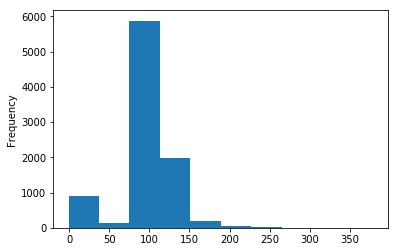

In [14]:
# create a histogram of duration, choosing an “appropriate” number of bins
movies['Duration_Minutes'].plot(kind='hist', bins=10)

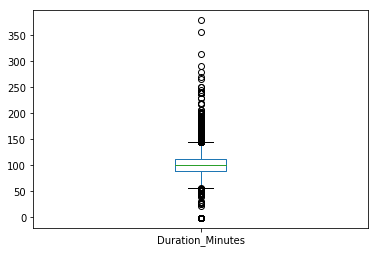

In [15]:
movies['Duration_Minutes'].plot(kind='box')

Count how many movies have average ratings :

C:\Python\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning: numpy.arange
  """


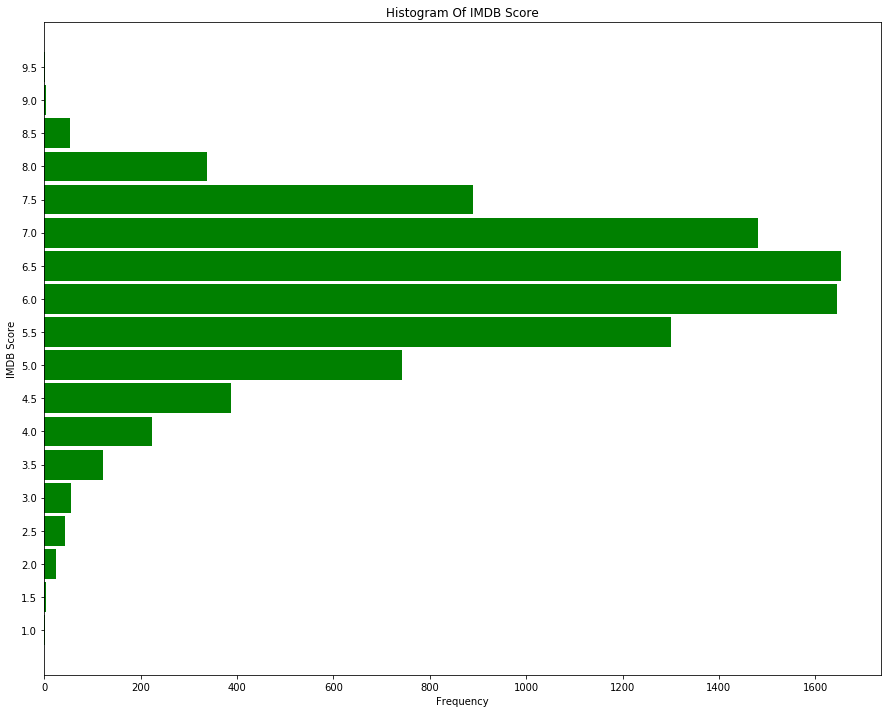

In [16]:
# movies[['Average_Rating' ,'Name']].groupby('Average_Rating').count()
imdbScore=[[]]
x=[]

for i in pl.frange(1,9.5,.5):
    imdbScore.append(len(movies.Average_Rating[(movies.Average_Rating>=i) & (movies.Average_Rating<i+.5)]))
    x.append(i)

del(imdbScore[0])

plt.figure(figsize=(15,12))
plt.title("Histogram Of IMDB Score")
plt.ylabel("IMDB Score")
plt.xlabel('Frequency')
plt.barh(x,imdbScore,height=.45 ,color='green')
plt.yticks(x)
plt.show()

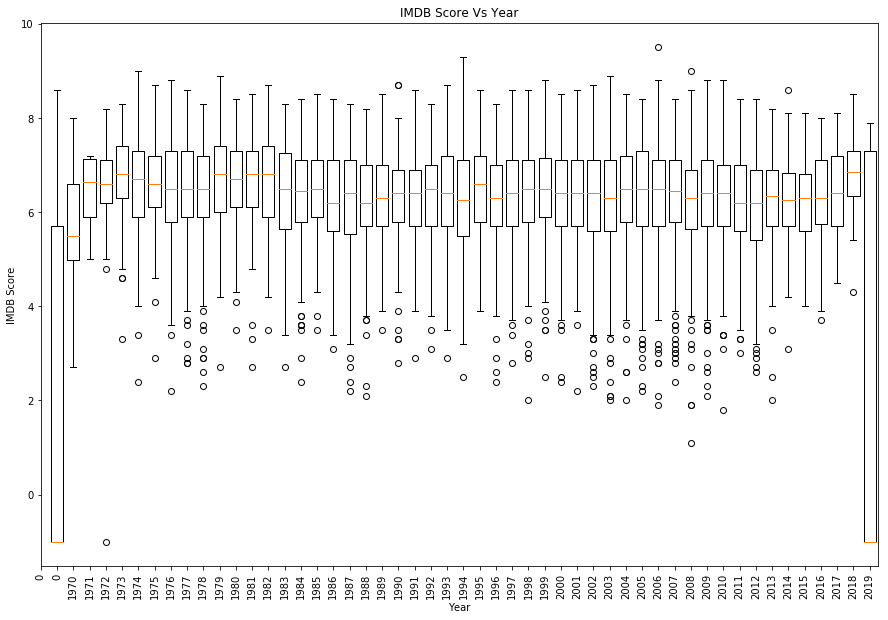

In [17]:
data=movies.dropna()
year=(movies.Year.unique()).astype(int)
year=sorted(year)

yearImdbScore=[]
numOfMovieByYear=[]

for i in year:
    tmp=movies.Average_Rating[movies.Year==i]
    yearImdbScore.append(tmp)
    numOfMovieByYear.append(len(tmp))



plt.figure(figsize=(15,10))
plt.title("IMDB Score Vs Year")
plt.ylabel("IMDB Score")
plt.xlabel('Year')
plt.boxplot(yearImdbScore,widths=.75)
year=list(np.insert(year,0,0))
plt.xticks(range(len(year)),year,rotation=90,fontsize=10)
plt.show()


Top Director VS Their Movie imdb rating

In [18]:
director=list(movies.Director.unique())
df=pd.DataFrame(columns=['director','directorScoreMean','directorImdbScore','directorMovieNUm'])

for i in director:
    tmp=list(movies.Average_Rating[movies.Director==i])
    if len(tmp)>1:
        df=df.append({'director': i,'directorScoreMean': sum(tmp)/len(tmp),'directorImdbScore': tmp,'directorMovieNUm' :len(tmp)},ignore_index=True)
    
tmp=(df.sort_values(['directorScoreMean'],ascending=False)).head(25)
directorByMeanScore=list(tmp.director)
directorByMeanScore.reverse()
ScoreByMeanScore=list(tmp.directorImdbScore)
ScoreByMeanScore.reverse()


tmp=(df.sort_values(['directorMovieNUm'],ascending=False)).head(25)
directorByMovieNum =list(tmp.director)
directorByMovieNum.reverse()
ScoreByMovieNum=list(tmp.directorImdbScore)
ScoreByMovieNum.reverse()

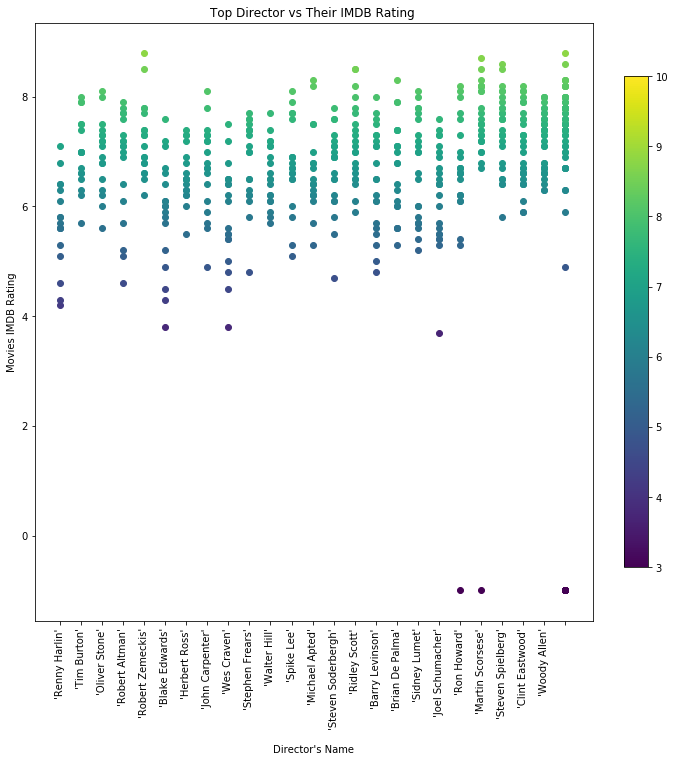

In [19]:
#directorByMovieNum
plt.figure(figsize=(11,11))
for i in range(len(directorByMovieNum)):
    for j in ScoreByMovieNum[i]:
        plt.scatter(i,j,c=j,vmin=3,vmax=10)


#tmp=plt.scatter(c=ScoreByMovieNum)
plt.colorbar(fraction=.04)
plt.title("Top Director vs Their IMDB Rating ")
plt.ylabel('Movies IMDB Rating')
plt.xlabel("\nDirector's Name")
plt.xticks(range(25),directorByMovieNum,rotation=90)

plt.show()

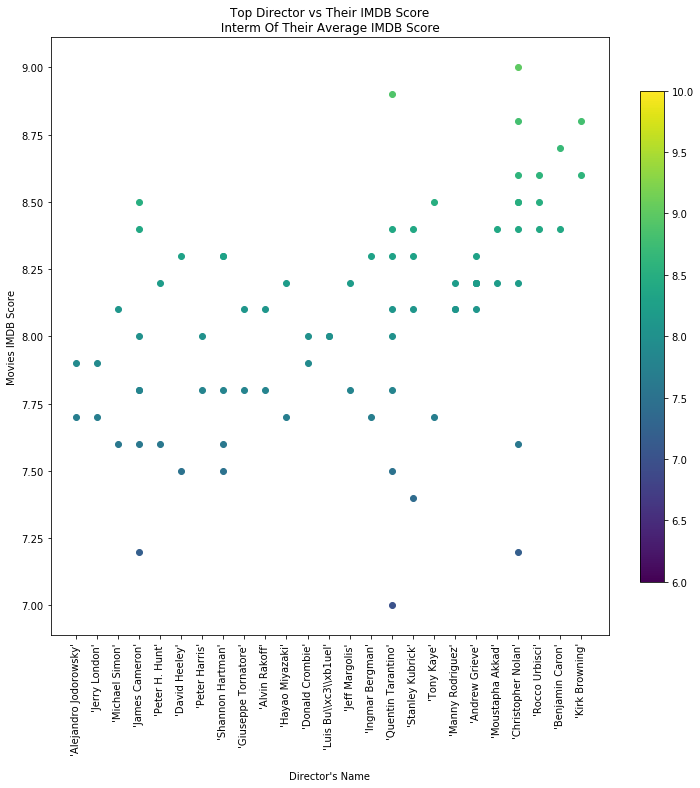

In [20]:
#directorByMeanScore
plt.figure(figsize=(11,11))
for i in range(len(directorByMeanScore)):
    for j in ScoreByMeanScore[i]:
        plt.scatter(i,j,c=j,vmin=6,vmax=10)

plt.xticks(range(25),directorByMeanScore,rotation=90)
plt.title("Top Director vs Their IMDB Score\n Interm Of Their Average IMDB Score ")
plt.ylabel('Movies IMDB Score')
plt.xlabel("\nDirector's Name")
plt.colorbar(fraction=.04)
plt.show()

Text(0,0.5,'Title Count')

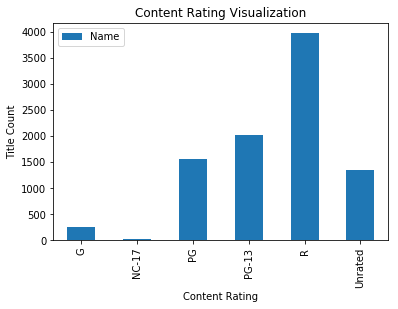

In [19]:
# use a visualization to display that same data, including a title and x and y labels
movies[['Rating' ,'Name']].groupby('Rating').count().plot(kind='bar', title='Content Rating Visualization')
plt.xlabel('Content Rating')
plt.ylabel('Title Count')

In [20]:
# calculate the average star rating for movies 2 hours or longer,
# and compare that with the average star rating for movies shorter than 2 hours
print('Avg. star rating for movies 2 hours or longer: ', movies[movies['Duration_Minutes'] >= 120]['Average_Rating'].mean(), 
 '\nAvg. star rating for movies shorter than 2 hours: ', movies[movies['Duration_Minutes'] < 120]['Average_Rating'].mean())

Avg. star rating for movies 2 hours or longer:  7.030188679245288 
Avg. star rating for movies shorter than 2 hours:  6.017805194805212


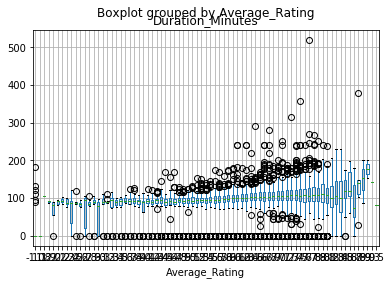

In [21]:
# use a visualization to detect whether there is a relationship between duration and star rating
movies.boxplot(column='Duration_Minutes', by='Average_Rating');

In [22]:
# calculate the average duration for each genre
movies[['Duration_Minutes','Genres']].groupby('Genres').mean()

,Duration_Minutes
Genres,
,65.833333
'Action',62.666667
"'Action', 'Adventure'",105.000000
"'Action', 'Adventure', 'Biography', 'Crime'",106.000000
"'Action', 'Adventure', 'Biography', 'Crime', 'History', 'Romance', 'Western'",110.000000
"'Action', 'Adventure', 'Biography', 'Drama', 'History', 'Romance', 'War'",176.000000
"'Action', 'Adventure', 'Biography', 'Drama', 'History', 'Romance', 'War', 'Western'",97.000000
"'Action', 'Adventure', 'Biography', 'Drama', 'History', 'Thriller'",122.000000
"'Action', 'Adventure', 'Biography', 'Drama', 'Sport', 'Western'",136.000000


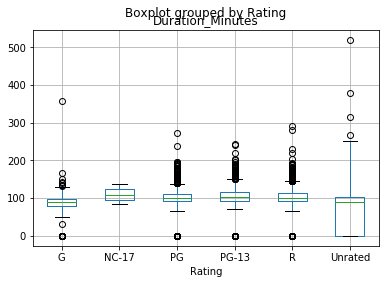

In [23]:
# visualize the relationship between content rating and duration
movies.boxplot(column='Duration_Minutes', by='Rating')

Check for Duplicacy

In [24]:
# check if there are multiple movies with the same title, and if so, determine if they are actually duplicates
result = movies[movies['Name'].isin(movies[movies.duplicated(['Name'])]['Name'])]
result.sort_values('Name')

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
8750,A Christmas Carol,1984.0,"'Drama', 'Family', 'Fantasy'",PG,100.0,"'George C. Scott', 'Frank Finlay', 'Angela Ple...",'Clive Donner',7.9,-1.0,NaN,-1.0,-1.000000e+00,"'English', 'Portuguese'",'EntertainmentPartnersLtd.'
8751,A Christmas Carol,1999.0,"'Drama', 'Fantasy'",PG,95.0,"'Patrick Stewart', 'Richard E. Grant', 'Joel G...",'David Hugh Jones',7.4,-1.0,NaN,-1.0,-1.000000e+00,'English',"'TNT', 'HallmarkEntertainment'"
1384,A Christmas Carol,2009.0,"'Animation', 'Drama', 'Family', 'Fantasy'",PG,96.0,"'Jim Carrey', 'Gary Oldman', 'Colin Firth', 'S...",'Robert Zemeckis',6.8,200000000.0,30051075.0,137855863.0,3.252866e+08,'English',"'WaltDisneyPictures', 'ImageMoversDigital', 'I..."
802,A Nightmare on Elm Street,2010.0,"'Crime', 'Drama', 'Horror', 'Mystery'",R,95.0,"'Jackie Earle Haley', 'Rooney Mara', 'Kyle Gal...",'Samuel Bayer',5.2,35000000.0,32902299.0,63075011.0,1.156640e+08,'English',"'NewLineCinema', 'PlatinumDunes'"
844,A Nightmare on Elm Street,1984.0,'Horror',R,91.0,"'Heather Langenkamp', 'Johnny Depp', 'Robert E...",'Wes Craven',7.5,1800000.0,1271000.0,25504513.0,-1.000000e+00,'English',"'NewLineCinema', 'MediaHomeEntertainment', 'Sm..."
9711,A Star Is Born,2018.0,"'Drama', 'Music', 'Romance'",R,136.0,"'Lady Gaga', 'Bradley Cooper', 'Sam Elliott', ...",'Bradley Cooper',7.8,36000000.0,42908051.0,215181496.0,-1.000000e+00,'English',"'WarnerBros.Pictures', 'LiveNationProductions'..."
3630,A Star Is Born,1976.0,"'Drama', 'Music', 'Romance'",R,139.0,"'Barbra Streisand', 'Kris Kristofferson', 'Gar...",'Frank Pierson',6.4,6000000.0,NaN,80000000.0,8.887010e+07,'English',"'BarwoodFilms', 'FirstArtists', 'WintersHollyw..."
8502,Alice in Wonderland,1999.0,"'Adventure', 'Comedy', 'Family', 'Fantasy'",PG,65.0,"'Tina Majorino', 'Whoopi Goldberg', 'Robbie Co...",'Nick Willing',6.3,21000000.0,NaN,-1.0,-1.000000e+00,'English',"'BabelsbergInternationalFilmProduktion', 'Hall..."
271,Alice in Wonderland,2010.0,"'Adventure', 'Family', 'Fantasy'",PG,108.0,"'Mia Wasikowska', 'Johnny Depp', 'Helena Bonha...",'Tim Burton',6.5,200000000.0,116101023.0,334191110.0,1.025467e+09,'English',"'WaltDisneyPictures', 'RothFilms', 'TeamTodd'"
7716,Amelia,2009.0,"'Adventure', 'Biography', 'Drama', 'Romance'",PG,111.0,"'Hilary Swank', 'Richard Gere', 'Ewan McGregor...",'Mira Nair',5.8,40000000.0,3904047.0,14241034.0,-1.000000e+00,'English',"'FoxSearchlightPictures', 'AvalonPictures', 'A..."


In [25]:
# calculate the average star rating for each genre, but only include genres with at least 10 movies
genres = movies['Genres'].value_counts()[movies['Genres'].value_counts() > 10].index
movies[movies['Genres'].isin(genres)].groupby('Genres')['Average_Rating'].mean()

Genres
'Action', 'Adventure'                                     6.469231
'Action', 'Adventure', 'Comedy'                           5.625000
'Action', 'Adventure', 'Drama'                            6.263636
'Action', 'Adventure', 'Drama', 'Thriller'                6.238095
'Action', 'Adventure', 'Fantasy'                          5.694118
'Action', 'Adventure', 'Fantasy', 'Sci-Fi'                5.861538
'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller'    4.900000
'Action', 'Adventure', 'Sci-Fi'                           6.345588
'Action', 'Adventure', 'Sci-Fi', 'Thriller'               6.495122
'Action', 'Adventure', 'Thriller'                         6.433333
'Action', 'Comedy'                                        5.773684
'Action', 'Comedy', 'Crime'                               6.064103
'Action', 'Comedy', 'Crime', 'Drama', 'Thriller'          5.618182
'Action', 'Comedy', 'Crime', 'Thriller'                   6.107692
'Action', 'Crime', 'Drama'                             

In [26]:
# Make a function which clean the data
def repp(string):
    return string.replace("'","").replace(",",",")[:-1]
#Apply that function to every entry    
movies_series = movies['Actors'].apply(repp)
#Declare a list to store the split values
actors_list = []
for movie_actors in movies_series:
    actors_list.append([e.strip() for e in movie_actors.split(',')])
#Declare a dictionary and see if the actor name key exist and then count accordingly.
actor_dict = {}
for actor in actors_list:
    for a in actor:
        if a in actor_dict:
            actor_dict[a] +=1
        else:
            actor_dict[a] = 1

actor_dict

{'John Travolta': 41,
 'Uma Thurman': 22,
 'Samuel L. Jackson': 52,
 'Bruce Willi': 4,
 'Andrew Garfield': 7,
 'Emma Stone': 13,
 'Jamie Foxx': 18,
 'Paul Giamatt': 4,
 'Tim Robbins': 27,
 'Morgan Freeman': 43,
 'Bob Gunton': 4,
 'William Sadle': 2,
 'Mark Hamill': 7,
 'Harrison Ford': 36,
 'Carrie Fisher': 9,
 'Alec Guinnes': 1,
 'Michael J. Fox': 21,
 'Christopher Lloyd': 17,
 'Lea Thompson': 10,
 'Crispin Glove': 3,
 'Emilio Estevez': 18,
 'Judd Nelson': 6,
 'Molly Ringwald': 8,
 'Ally Sheed': 1,
 'Sean Astin': 10,
 'Josh Brolin': 18,
 'Jeff Cohen': 1,
 'Corey Feldma': 2,
 'Jodie Foster': 25,
 'Anthony Hopkins': 50,
 'Lawrence A. Bonney': 1,
 'Kasi Lemmon': 3,
 'Sam Neill': 27,
 'Laura Dern': 10,
 'Jeff Goldblum': 20,
 'Richard Attenboroug': 1,
 'Matthew Broderick': 27,
 'Jeremy Irons': 22,
 'James Earl Jones': 18,
 'Whoopi Goldber': 2,
 'Brad Pitt': 35,
 'Kevin Spacey': 29,
 'Andrew Kevin Walke': 1,
 'Tom Hanks': 40,
 'Tim Allen': 17,
 'Don Rickles': 1,
 'Jim Varne': 1,
 'Jeff Brid

In [27]:
#Sorted list of Actors
import operator
actor_movie_count = sorted(actor_dict.items(), key=operator.itemgetter(1))
actor_movie_count

[('Alec Guinnes', 1),
 ('Ally Sheed', 1),
 ('Jeff Cohen', 1),
 ('Lawrence A. Bonney', 1),
 ('Richard Attenboroug', 1),
 ('Andrew Kevin Walke', 1),
 ('Don Rickles', 1),
 ('Jim Varne', 1),
 ('Jake Lloy', 1),
 ('Jeff Kah', 1),
 ('Eli Roth', 1),
 ('M\\\\xc3\\\\xa9lanie Lauren', 1),
 ('Leonard Nimo', 1),
 ('Jordan Nagai', 1),
 ('John Ratzenberger', 1),
 ('Craig Ferguso', 1),
 ('Garrett M. Brow', 1),
 ('Irrfan Kha', 1),
 ('Rihann', 1),
 ('Julie Walter', 1),
 ('Anna Hutchison', 1),
 ('Fran Kran', 1),
 ('Rachel Woo', 1),
 ('America Ferrer', 1),
 ('Randy Couture', 1),
 ('Jean-Claude Van Damm', 1),
 ('Julene Renee', 1),
 ('Zabryna Guevar', 1),
 ('Samantha Morto', 1),
 ('Scoot McNair', 1),
 ('Suraj Sharma', 1),
 ('Adil Hussain', 1),
 ('Tab', 1),
 ('Paul Dan', 1),
 ('Mandy Gonzale', 1),
 ('Thomas Mann', 1),
 ('Oliver Cooper', 1),
 ('Jonathan Daniel Brown', 1),
 ('Dax Flam', 1),
 ('Logan Marshall-Green', 1),
 ('Isabel Lucas', 1),
 ('Josh Pec', 1),
 ('Chris Pin', 1),
 ('Juliet Rylance', 1),
 ('Sam C

In [29]:
# import random
# from wordcloud import WordCloud, STOPWORDS
# text = (str(movies['Actors']))
# plt.subplots(figsize=(20,15))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1500,
#                           height=1200
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('Actors')
# plt.axis('off')
# plt.show()

In [30]:
# movies["Genres"].value_counts()

In [31]:
# seperate_genre='Action','Adventure','Animation','Biography','Comedy','Crime','Drama','Fantasy','Family','History','Horror','Music','Musical','Mystery','Romance','Sci-Fi','Sport','Thriller','War','Western'
# for genre in seperate_genre:
#     df = movies['Genres'].str.contains(genre).fillna(False)
#    # print('The total number of movies with ',Genres,'=',len(movies[df]))
#     f, ax = plt.subplots(figsize=(20, 20))
#     sns.countplot(x='Year', data=movies[df], palette="Greens_d");
#     plt.title(genre)
   

In [32]:
# movies.Director.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# # plt.title('TOP 10 Directors OF MOVIES')

In [33]:
# movies.Actors.value_counts()[:10].plot.pie(autopct='%1.1f%%',figsize=(10,10))
# plt.title('TOP 10 Actors OF MOVIES')

In [34]:
# movies["Year"].value_counts().to_frame()

In [28]:
g=movies.groupby('Year')
g.count().head()

,Name,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
Year,,,,,,,,,,,,,
0.0,274,274,274,274,274,274,274,274,0,274,274,128,274
1970.0,12,12,12,12,12,12,12,12,0,12,12,12,12
1971.0,4,4,4,4,4,4,4,4,0,4,4,4,4
1972.0,57,57,57,57,57,57,57,57,2,57,57,57,57
1973.0,152,152,152,152,152,152,152,152,5,152,152,152,152


In [29]:
#top 10 rating movies 
Sortedrating= movies.sort_values(['Average_Rating'], ascending=False)
Sortedrating.head(10)

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
9029,Yanni Live! The Concert Event,2006.0,'Music',Unrated,82.0,"'Charlie Adams', 'Michelle Amato', 'Kristen Au...","'George Veras', 'ProReviews', 'Excellent music...",9.5,-1.0,NaN,-1.0,-1.000000e+00,'English',
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"'Tim Robbins', 'Morgan Freeman', 'Bob Gunton',...",'Frank Darabont',9.3,25000000.0,727326.0,28341469.0,5.850000e+07,'English','CastleRockEntertainment'
34,The Dark Knight,2008.0,"'Action', 'Crime', 'Drama', 'Thriller'",PG-13,152.0,"'Christian Bale', 'Heath Ledger', 'Aaron Eckha...",'Christopher Nolan',9.0,185000000.0,158411483.0,534858444.0,1.004558e+09,"'English', 'Mandarin'","'WarnerBros.', 'LegendaryEntertainment', 'Sync..."
194,The Godfather: Part II,1974.0,"'Crime', 'Drama'",R,202.0,"'Al Pacino', 'Robert De Niro', 'Robert Duvall'...",'Francis Ford Coppola',9.0,13000000.0,NaN,57300000.0,-1.000000e+00,"'English', 'Italian', 'Spanish', 'Latin', 'Sic...","'ParamountPictures', 'TheCoppolaCompany'"
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"'John Travolta', 'Uma Thurman', 'Samuel L. Jac...",'Quentin Tarantino',8.9,8000000.0,9311882.0,107928762.0,2.139288e+08,"'English', 'Spanish', 'French'","'Miramax', 'ABandApart', 'JerseyFilms'"
23,The Lord of the Rings: The Return of the King,2003.0,"'Adventure', 'Drama', 'Fantasy'",PG-13,201.0,"'Elijah Wood', 'Viggo Mortensen', 'Ian McKelle...",'Peter Jackson',8.9,94000000.0,72629713.0,377845905.0,1.119930e+09,"'English', 'Quenya', 'OldEnglish', 'Sindarin'","'NewLineCinema', 'WingNutFilms', 'TheSaulZaent..."
9253,Strangers: The Story of a Mother and Daughter,1979.0,"'Drama', 'actor'",Unrated,88.0,"'Bette Davis', 'Gena Rowlands', 'Ford Rainey',...",'Milton Katselas',8.9,-1.0,NaN,-1.0,-1.000000e+00,'English','Chris/RoseProductions'
9283,The Taming of the Shrew,1976.0,"'Comedy', 'Romance', 'actor'",Unrated,102.0,"'Raye Birk', 'Earl Boen', 'Ron Boussom', 'Barb...",'Kirk Browning',8.8,-1.0,NaN,-1.0,-1.000000e+00,'English',"'AmericanConservatoryTheatre', 'PublicBroadcas..."
14,Fight Club,1999.0,'Drama',R,139.0,"'Brad Pitt', 'Edward Norton', 'Meat Loaf', 'Za...",'David Fincher',8.8,63000000.0,11035485.0,37030102.0,7.100000e+07,'English',"'Fox2000Pictures', 'RegencyEnterprises', 'Lins..."
8109,Kissology: The Ultimate Kiss Collection,2006.0,"'Documentary', 'Biography', 'Music', 'actor'",Unrated,379.0,"'Gene Simmons', 'Paul Stanley', 'Ace Frehley',...",,8.8,-1.0,NaN,-1.0,-1.000000e+00,'English',


In [30]:
# low rated movies
lowratedmovies= movies.query('(Average_Rating > 0) & (Average_Rating < 3.0)')
lowratedmovies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
156,The Cloth,2013.0,"'Action', 'Fantasy', 'Horror'",Unrated,88.0,"'Danny Trejo', 'Perla Rodr\\xc3\\xadguez', 'Er...",'Justin Price',2.5,4000000.0,NaN,-1.0,-1.0,'English',"'EminenceProductions', 'ClothFilm'"
187,Devils of War,2013.0,"'Action', 'Horror'",Unrated,74.0,"'Lawrence Anthony', 'Jerry L. Buxbaum', 'Jamin...","'Eli Dorsey', 'Eli Dorsey', 'Bezenby', 'Kind o...",2.0,-1.0,NaN,-1.0,-1.0,'English',
766,Epic Movie,2007.0,"'Adventure', 'Comedy'",PG-13,86.0,"'Kal Penn', 'Jennifer Coolidge', 'Fred Willard...","'Jason Friedberg', 'Aaron Seltzer'",2.4,20000000.0,18612544.0,39739367.0,86865564.0,'English',"'RegencyEnterprises', 'NewRegencyPictures', 'P..."
952,Disaster Movie,2008.0,'Comedy',PG-13,87.0,"'Carmen Electra', 'Vanessa Lachey', 'Nicole Pa...","'Jason Friedberg', 'Aaron Seltzer'",1.9,20000000.0,6945535.0,14190901.0,34816824.0,'English',"'Lionsgate', 'GrosvenorParkMedia', '3intheBox'"
1376,Dragonball: Evolution,2009.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'T...",PG,85.0,"'Justin Chatwin', 'James Marsters', 'Yun-Fat C...",'James Wong',2.6,30000000.0,4756488.0,9353573.0,57497699.0,"'English', 'Japanese', 'Hindi'","'TwentiethCenturyFox', 'DuneEntertainment', 'S..."


In [31]:
Sortedrevenue= movies.sort_values(['Budget'], ascending=False)

In [32]:
#top 5 high revenue movies
Sortedrevenue.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
9522,Avengers: Infinity War,2018.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,149.0,"'Robert Downey Jr.', 'Chris Hemsworth', 'Mark ...","'Anthony Russo', 'Joe Russo'",8.5,321000000.0,257698183.0,678815482.0,2.048710e+09,'English',"'MarvelStudios', 'JasonRobertsProductions', 'S..."
460,Pirates of the Caribbean: At World\'s End,2007.0,"'Action', 'Adventure', 'Fantasy'",PG-13,169.0,"'Johnny Depp', 'Orlando Bloom', 'Keira Knightl...",'Gore Verbinski',7.1,300000000.0,139802190.0,309420425.0,9.634204e+08,'English',"'WaltDisneyPictures', 'JerryBruckheimerFilms',..."
9408,Justice League,2017.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG-13,120.0,"'Ben Affleck', 'Gal Gadot', 'Jason Momoa', 'Ez...",'Zack Snyder',6.5,300000000.0,93842239.0,229024295.0,6.147297e+08,"'English', 'Irish', 'Russian', 'Icelandic'","'WarnerBros.', 'RatPacEntertainment', 'DCEnter..."
6617,Tangled,2010.0,"'Animation', 'Adventure', 'Comedy', 'Family', ...",PG,100.0,"'Mandy Moore', 'Zachary Levi', 'Donna Murphy',...","'Nathan Greno', 'Byron Howard'",7.8,260000000.0,48767052.0,200821936.0,5.917949e+08,'English',"'WaltDisneyAnimationStudios', 'WaltDisneyPictu..."
461,Spider-Man 3,2007.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,139.0,"'Tobey Maguire', 'Kirsten Dunst', 'Topher Grac...",'Sam Raimi',6.2,258000000.0,151116516.0,336530303.0,5.543413e+08,"'English', 'French'","'ColumbiaPicturesCorporation', 'MarvelStudios'..."


In [33]:
m= Sortedrevenue.query('(Budget > 500)')
print('number of movies with more than half million revenue:')
len(m)

number of movies with more than half million revenue:


5591

In [34]:
n= Sortedrevenue.query('(Budget < 500)')
print('number of movies with less than half million revenue:')
len(n)

number of movies with less than half million revenue:


3593

In [35]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9184 entries, 0 to 9836
Data columns (total 14 columns):
Name                  9184 non-null object
Year                  9184 non-null float64
Genres                9184 non-null object
Rating                9184 non-null object
Duration_Minutes      9184 non-null float64
Actors                9184 non-null object
Director              9184 non-null object
Average_Rating        9184 non-null float64
Budget                9184 non-null float64
Opening Weekend       5241 non-null float64
Gross US              9184 non-null float64
Gross WW              9184 non-null float64
Language              9035 non-null object
Production Company    9184 non-null object
dtypes: float64(7), object(7)
memory usage: 1.1+ MB


In [43]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(m['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN HIGH REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [44]:
# from wordcloud import WordCloud, STOPWORDS
# plt.subplots(figsize=(10,10))
# text = (str(n['Actors']))
# wordcloud = WordCloud(
#                           stopwords=STOPWORDS,
#                           background_color='white',
#                           width=1200,
#                           height=1000
#                          ).generate(text)


# plt.imshow(wordcloud)
# plt.title('ACTORS IN LOW REVENUE MOVIES')
# plt.axis('off')
# plt.show()

In [36]:
numeric_features=movies._get_numeric_data().columns.values.tolist()
numeric_features

['Year',
 'Duration_Minutes',
 'Average_Rating',
 'Budget',
 'Opening Weekend',
 'Gross US',
 'Gross WW']

# Correlation heatmap

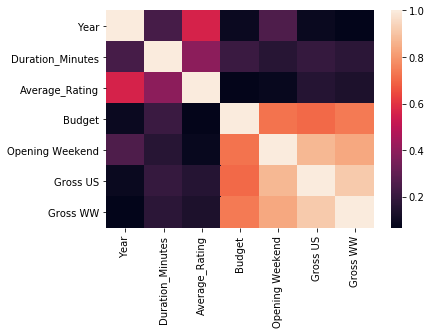

In [37]:
col = list(movies.describe().columns)
features=col
features
sns.heatmap(movies[features].corr())

In [38]:
correlation=movies.corr()
correlation

,Year,Duration_Minutes,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW
Year,1.000000,0.238064,0.559384,0.095060,0.257494,0.091612,0.066219
Duration_Minutes,0.238064,1.000000,0.397737,0.208564,0.161256,0.200243,0.173726
Average_Rating,0.559384,0.397737,1.000000,0.070246,0.087136,0.158588,0.138021
Budget,0.095060,0.208564,0.070246,1.000000,0.723730,0.705616,0.737544
Opening Weekend,0.257494,0.161256,0.087136,0.723730,1.000000,0.872806,0.837549
Gross US,0.091612,0.200243,0.158588,0.705616,0.872806,1.000000,0.917344
Gross WW,0.066219,0.173726,0.138021,0.737544,0.837549,0.917344,1.000000


In [39]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"'John Travolta', 'Uma Thurman', 'Samuel L. Jac...",'Quentin Tarantino',8.9,8000000.0,9311882.0,107928762.0,213928762.0,"'English', 'Spanish', 'French'","'Miramax', 'ABandApart', 'JerseyFilms'"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"'Andrew Garfield', 'Emma Stone', 'Jamie Foxx',...",'Marc Webb',6.6,200000000.0,91608337.0,202853933.0,708982323.0,'English',"'MarvelEnterprises', 'AviAradProductions', 'Co..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"'Tim Robbins', 'Morgan Freeman', 'Bob Gunton',...",'Frank Darabont',9.3,25000000.0,727326.0,28341469.0,58500000.0,'English','CastleRockEntertainment'
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"'Mark Hamill', 'Harrison Ford', 'Carrie Fisher...",'George Lucas',8.6,11000000.0,1554475.0,322740140.0,775398007.0,'English',"'Lucasfilm', 'TwentiethCenturyFox'"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"'Michael J. Fox', 'Christopher Lloyd', 'Lea Th...",'Robert Zemeckis',8.5,19000000.0,11332134.0,210609762.0,381109762.0,'English',"'UniversalPictures', 'AmblinEntertainment', 'U..."


In [40]:
movies

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"'John Travolta', 'Uma Thurman', 'Samuel L. Jac...",'Quentin Tarantino',8.9,8000000.0,9311882.0,107928762.0,2.139288e+08,"'English', 'Spanish', 'French'","'Miramax', 'ABandApart', 'JerseyFilms'"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"'Andrew Garfield', 'Emma Stone', 'Jamie Foxx',...",'Marc Webb',6.6,200000000.0,91608337.0,202853933.0,7.089823e+08,'English',"'MarvelEnterprises', 'AviAradProductions', 'Co..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"'Tim Robbins', 'Morgan Freeman', 'Bob Gunton',...",'Frank Darabont',9.3,25000000.0,727326.0,28341469.0,5.850000e+07,'English','CastleRockEntertainment'
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"'Mark Hamill', 'Harrison Ford', 'Carrie Fisher...",'George Lucas',8.6,11000000.0,1554475.0,322740140.0,7.753980e+08,'English',"'Lucasfilm', 'TwentiethCenturyFox'"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"'Michael J. Fox', 'Christopher Lloyd', 'Lea Th...",'Robert Zemeckis',8.5,19000000.0,11332134.0,210609762.0,3.811098e+08,'English',"'UniversalPictures', 'AmblinEntertainment', 'U..."
5,The Breakfast Club,1985.0,"'Comedy', 'Drama'",R,97.0,"'Emilio Estevez', 'Judd Nelson', 'Molly Ringwa...",'John Hughes',7.9,1000000.0,5107599.0,45875171.0,5.152517e+07,'English',"'UniversalPictures', 'A&M;Films', 'ChannelProd..."
6,The Goonies,1985.0,"'Adventure', 'Comedy', 'Family'",PG,114.0,"'Sean Astin', 'Josh Brolin', 'Jeff Cohen', 'Co...",'Richard Donner',7.8,19000000.0,9105913.0,61503218.0,-1.000000e+00,"'English', 'Spanish', 'Cantonese', 'Italian'","'WarnerBros.', 'AmblinEntertainment'"
7,The Silence of the Lambs,1991.0,"'Crime', 'Drama', 'Thriller'",R,118.0,"'Jodie Foster', 'Anthony Hopkins', 'Lawrence A...",'Jonathan Demme',8.6,19000000.0,13766814.0,130742922.0,2.727429e+08,'English',"'StrongHeart/DemmeProduction', 'OrionPictures'"
8,Jurassic Park,1993.0,"'Adventure', 'Sci-Fi', 'Thriller'",PG-13,127.0,"'Sam Neill', 'Laura Dern', 'Jeff Goldblum', 'R...",'Steven Spielberg',8.1,63000000.0,50159460.0,402453882.0,1.029154e+09,"'English', 'Spanish'","'UniversalPictures', 'AmblinEntertainment'"
9,The Lion King,1994.0,"'Animation', 'Adventure', 'Drama', 'Family', '...",G,88.0,"'Matthew Broderick', 'Jeremy Irons', 'James Ea...","'Roger Allers', 'Rob Minkoff'",8.5,45000000.0,1825849.0,312900000.0,9.874838e+08,"'English', 'Swahili', 'Xhosa', 'Zulu'","'WaltDisneyPictures', 'WaltDisneyFeatureAnimat..."


# Dummy Encoding for Genres:

In [41]:
movies["Genres"] = movies["Genres"].str.replace('[','')
movies["Genres"] = movies["Genres"].str.replace(']','')
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"'John Travolta', 'Uma Thurman', 'Samuel L. Jac...",'Quentin Tarantino',8.9,8000000.0,9311882.0,107928762.0,213928762.0,"'English', 'Spanish', 'French'","'Miramax', 'ABandApart', 'JerseyFilms'"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"'Andrew Garfield', 'Emma Stone', 'Jamie Foxx',...",'Marc Webb',6.6,200000000.0,91608337.0,202853933.0,708982323.0,'English',"'MarvelEnterprises', 'AviAradProductions', 'Co..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"'Tim Robbins', 'Morgan Freeman', 'Bob Gunton',...",'Frank Darabont',9.3,25000000.0,727326.0,28341469.0,58500000.0,'English','CastleRockEntertainment'
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"'Mark Hamill', 'Harrison Ford', 'Carrie Fisher...",'George Lucas',8.6,11000000.0,1554475.0,322740140.0,775398007.0,'English',"'Lucasfilm', 'TwentiethCenturyFox'"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"'Michael J. Fox', 'Christopher Lloyd', 'Lea Th...",'Robert Zemeckis',8.5,19000000.0,11332134.0,210609762.0,381109762.0,'English',"'UniversalPictures', 'AmblinEntertainment', 'U..."


In [51]:
#movies= movies.set_index('Name').Genres.str.split(',', expand=True).stack() # this is converting the dataframe to series.. do we need this??

In [42]:
movies.head()

,Name,Year,Genres,Rating,Duration_Minutes,Actors,Director,Average_Rating,Budget,Opening Weekend,Gross US,Gross WW,Language,Production Company
0,Pulp Fiction,1994.0,"'Crime', 'Drama'",R,154.0,"'John Travolta', 'Uma Thurman', 'Samuel L. Jac...",'Quentin Tarantino',8.9,8000000.0,9311882.0,107928762.0,213928762.0,"'English', 'Spanish', 'French'","'Miramax', 'ABandApart', 'JerseyFilms'"
1,The Amazing Spider-Man 2,2014.0,"'Action', 'Adventure', 'Sci-Fi'",PG-13,142.0,"'Andrew Garfield', 'Emma Stone', 'Jamie Foxx',...",'Marc Webb',6.6,200000000.0,91608337.0,202853933.0,708982323.0,'English',"'MarvelEnterprises', 'AviAradProductions', 'Co..."
2,The Shawshank Redemption,1994.0,'Drama',R,142.0,"'Tim Robbins', 'Morgan Freeman', 'Bob Gunton',...",'Frank Darabont',9.3,25000000.0,727326.0,28341469.0,58500000.0,'English','CastleRockEntertainment'
3,Star Wars: Episode IV - A New Hope,1977.0,"'Action', 'Adventure', 'Fantasy', 'Sci-Fi'",PG,121.0,"'Mark Hamill', 'Harrison Ford', 'Carrie Fisher...",'George Lucas',8.6,11000000.0,1554475.0,322740140.0,775398007.0,'English',"'Lucasfilm', 'TwentiethCenturyFox'"
4,Back to the Future,1985.0,"'Adventure', 'Comedy', 'Sci-Fi'",PG,116.0,"'Michael J. Fox', 'Christopher Lloyd', 'Lea Th...",'Robert Zemeckis',8.5,19000000.0,11332134.0,210609762.0,381109762.0,'English',"'UniversalPictures', 'AmblinEntertainment', 'U..."


In [53]:
# pd.get_dummies(movies).groupby(level=0).sum()

In [35]:
movies.to_excel('output.xlsx')

In [43]:
movies.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            9826, 9827, 9828, 9829, 9830, 9831, 9832, 9834, 9835, 9836],
           dtype='int64', length=9184)

In [44]:
#Need to change all movie ratings that are NC-17 to Unrated
movies["Rating"] = movies["Rating"].replace('NC-17', 'Unrated')

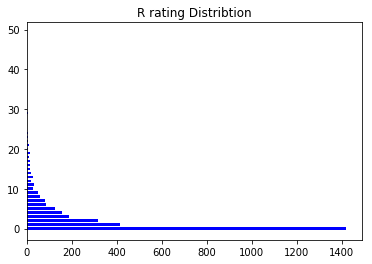

Mean Value:  22307293.404173356


In [45]:
R = movies[movies["Rating"] == 'R']
R = R[R["Gross US"] > 0]
R = R.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingR = R.groupby(pd.cut(R["Gross US"], groups)).count()
y_pos = np.arange(len(groupingR))
plt.barh(y_pos , groupingR["Gross US"], 1/1.5, color="blue")
plt.title("R rating Distribtion")
plt.show()
print("Mean Value: ", R["Gross US"].mean())

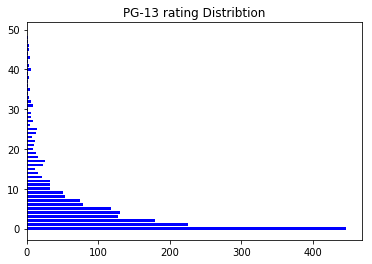

Mean Value:  53138836.04487179


In [46]:
PG13 = movies[movies["Rating"] == 'PG-13']
PG13 = PG13[PG13["Gross US"] > 0]
PG13 = PG13.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingPG13 = PG13.groupby(pd.cut(PG13["Gross US"], groups)).count()
y_pos = np.arange(len(groupingPG13))
plt.barh(y_pos , groupingPG13["Gross US"], 1/1.5, color="blue")
plt.title("PG-13 rating Distribtion")
plt.show()
print("Mean Value: ", PG13["Gross US"].mean())

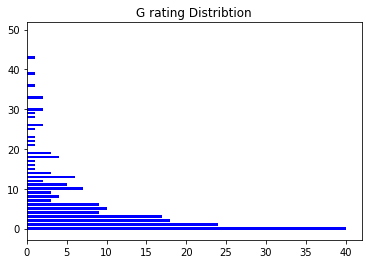

Mean Value:  54896717.31550802


In [47]:
G = movies[movies["Rating"] == 'G']
G = G[G["Gross US"] > 0]
G = G.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingG = G.groupby(pd.cut(G["Gross US"], groups)).count()
y_pos = np.arange(len(groupingG))
plt.barh(y_pos , groupingG["Gross US"], 1/1.5, color="blue")
plt.title("G rating Distribtion")
plt.show()
print("Mean Value: ", G["Gross US"].mean())

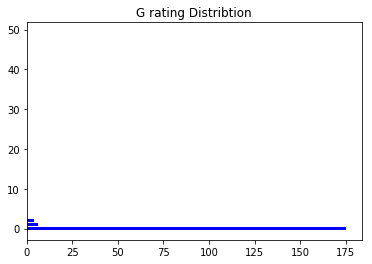

Mean Value:  1263131.8216216217


In [48]:
UN = movies[movies["Rating"] == 'Unrated']
UN = UN[UN["Gross US"] > 0]
UN = UN.sort_values(by=['Gross US'])
groups = []
for i in range(51):
    groups.append(i * 36307070/5 + 1)
groupingUN = UN.groupby(pd.cut(UN["Gross US"], groups)).count()
y_pos = np.arange(len(groupingUN))
plt.barh(y_pos , groupingUN["Gross US"], 1/1.5, color="blue")
plt.title("G rating Distribtion")
plt.show()
print("Mean Value: ", UN["Gross US"].mean())

In [54]:
#Checking to see if R and PG-13 are statistically different
print("R-PG13: ", stats.ttest_ind(R["Gross US"], PG13["Gross US"], equal_var = False))
#print("R-PG: ", stats.ttest_ind(R["Gross US"], PG["Gross US"], equal_var = False))
print("R-G: ", stats.ttest_ind(R["Gross US"], G["Gross US"], equal_var = False))
#print("PG13-PG: ", stats.ttest_ind(PG13["Gross US"], PG["Gross US"], equal_var = False))
print("PG13-G: ", stats.ttest_ind(PG13["Gross US"], G["Gross US"], equal_var = False))
#print("PG-G: ", stats.ttest_ind(PG["Gross US"], G["Gross US"], equal_var = False))
print("UN-R: ", stats.ttest_ind(UN["Gross US"], R["Gross US"], equal_var = False))
print("UN-PG13: ", stats.ttest_ind(UN["Gross US"], PG13["Gross US"], equal_var = False))
#print("UN-PG: ", stats.ttest_ind(UN["Gross US"], PG["Gross US"], equal_var = False))
print("UN-G: ", stats.ttest_ind(UN["Gross US"], G["Gross US"], equal_var = False))

R-PG13:  Ttest_indResult(statistic=-15.765565935594715, pvalue=3.239829775401504e-53)
R-G:  Ttest_indResult(statistic=-6.152063261228085, pvalue=4.397966448582058e-09)
PG13-G:  Ttest_indResult(statistic=-0.3149019814319445, pvalue=0.7531154518471694)
UN-R:  Ttest_indResult(statistic=-32.652706760406005, pvalue=2.4595612817598035e-200)
UN-PG13:  Ttest_indResult(statistic=-27.66550759476372, pvalue=4.035877649567761e-142)
UN-G:  Ttest_indResult(statistic=-10.180780276451426, pvalue=1.2102806363187675e-19)


Statiscally non of these values with high accuracy are equal to eachother. This allows us to say that each rating has statiscally different value. Lets now replace the Rating with the value of the mean of the rating to signify the value that the rating has upon the movie.

In [49]:
movies["Rating"] = movies["Rating"].replace('R', R["Gross US"].mean())
movies["Rating"] = movies["Rating"].replace('PG-13', PG13["Gross US"].mean())
movies["Rating"] = movies["Rating"].replace('PG', PG["Gross US"].mean())
movies["Rating"] = movies["Rating"].replace('G', G["Gross US"].mean())
movies["Rating"] = movies["Rating"].replace('Unrated', UN["Gross US"].mean())
movies["Rating"] = movies["Rating"].astype(float)
print(movies)

NameError: name 'PG' is not defined